# 引言

## Transformer

<div>
    <img src="images/transformer.png" width="600"/>
    <img src="images/transformer1.png" width="600"/><br>
    <img src="images/attention0.png" width="600"/>
    <!-- <img src="images/attention0.png"/> -->
</div>

# llama3 implemented from scratch using numpy
在这个文件中，我使用numpy从头开始实现了 llama3，一次一个张量和矩阵乘法。
<br>
此外，我将直接从 meta 所提供的 llama3 的模型文件中加载张量，所以运行此文件前需要下载权重。<br>
官方权重下载链接： https://llama.meta.com/llama-downloads/<br>
numpy实现参考：https://github.com/naklecha/llama3-from-scratch
<div>
    <img src="images/archi.png"/>
</div>

## 分词器（tokenizer）
im not going to implement a bpe tokenizer (but andrej karpathy has a really clean implementation)<br>
这里不实现 bpe 分词器（具体可参考 https://llmbook-zh.github.io/LLMBook.pdf 4.3.1 BPE 分词）。


<div>
    <img src="images/BPE_workflow.png" width="600"/>
</div>


In [785]:
from pathlib import Path
import tiktoken
from tiktoken.load import load_tiktoken_bpe
import torch
import json
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
Model_Home = "../Meta-Llama-3/Meta-Llama-3-8B/original/"

In [389]:
tokenizer_path = Model_Home + "tokenizer.model"
special_tokens = [
            "<|begin_of_text|>",
            "<|end_of_text|>",
            "<|reserved_special_token_0|>",
            "<|reserved_special_token_1|>",
            "<|reserved_special_token_2|>",
            "<|reserved_special_token_3|>",
            "<|start_header_id|>",
            "<|end_header_id|>",
            "<|reserved_special_token_4|>",
            "<|eot_id|>",  # end of turn
        ] + [f"<|reserved_special_token_{i}|>" for i in range(5, 256 - 5)]

mergeable_ranks = load_tiktoken_bpe(tokenizer_path)
tokenizer = tiktoken.Encoding(
    name=Path(tokenizer_path).name,
    pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+",
    mergeable_ranks=mergeable_ranks,
    special_tokens={token: len(mergeable_ranks) + i for i, token in enumerate(special_tokens)},
)


In [391]:
print(tokenizer.encode("hello world!"))
tokenizer.decode(tokenizer.encode("hello world!"))

[15339, 1917, 0]


'hello world!'

## 读取模型文件
通常，阅读此内容就可以看到模型类别的编写方式以及其中的变量名称。
<br>
因为我们是从头开始实现 llama3，所以我们将一次读取一个张量内容。
<div>
    <img src="images/model.png" width="600"/>
</div>

In [392]:
model = torch.load(Model_Home +"consolidated.00.pth")
print(json.dumps(list(model.keys())[:20], indent=4))

[
    "tok_embeddings.weight",
    "layers.0.attention.wq.weight",
    "layers.0.attention.wk.weight",
    "layers.0.attention.wv.weight",
    "layers.0.attention.wo.weight",
    "layers.0.feed_forward.w1.weight",
    "layers.0.feed_forward.w3.weight",
    "layers.0.feed_forward.w2.weight",
    "layers.0.attention_norm.weight",
    "layers.0.ffn_norm.weight",
    "layers.1.attention.wq.weight",
    "layers.1.attention.wk.weight",
    "layers.1.attention.wv.weight",
    "layers.1.attention.wo.weight",
    "layers.1.feed_forward.w1.weight",
    "layers.1.feed_forward.w3.weight",
    "layers.1.feed_forward.w2.weight",
    "layers.1.attention_norm.weight",
    "layers.1.ffn_norm.weight",
    "layers.2.attention.wq.weight"
]


In [796]:
list(model.keys())

['tok_embeddings.weight',
 'layers.0.attention.wq.weight',
 'layers.0.attention.wk.weight',
 'layers.0.attention.wv.weight',
 'layers.0.attention.wo.weight',
 'layers.0.feed_forward.w1.weight',
 'layers.0.feed_forward.w3.weight',
 'layers.0.feed_forward.w2.weight',
 'layers.0.attention_norm.weight',
 'layers.0.ffn_norm.weight',
 'layers.1.attention.wq.weight',
 'layers.1.attention.wk.weight',
 'layers.1.attention.wv.weight',
 'layers.1.attention.wo.weight',
 'layers.1.feed_forward.w1.weight',
 'layers.1.feed_forward.w3.weight',
 'layers.1.feed_forward.w2.weight',
 'layers.1.attention_norm.weight',
 'layers.1.ffn_norm.weight',
 'layers.2.attention.wq.weight',
 'layers.2.attention.wk.weight',
 'layers.2.attention.wv.weight',
 'layers.2.attention.wo.weight',
 'layers.2.feed_forward.w1.weight',
 'layers.2.feed_forward.w3.weight',
 'layers.2.feed_forward.w2.weight',
 'layers.2.attention_norm.weight',
 'layers.2.ffn_norm.weight',
 'layers.3.attention.wq.weight',
 'layers.3.attention.wk.weigh

In [394]:
# 查看模型参数文件
with open(Model_Home + "params.json", "r") as f:
    config = json.load(f)
config

{'dim': 4096,
 'n_layers': 32,
 'n_heads': 32,
 'n_kv_heads': 8,
 'vocab_size': 128256,
 'multiple_of': 1024,
 'ffn_dim_multiplier': 1.3,
 'norm_eps': 1e-05,
 'rope_theta': 500000.0}

## 我们使用配置文件来推断有关模型的详细信息
1. n_layers：该模型有 32 个transformer层
2. n_heads：每个多头注意力块有 32 个头
3. vocab_size：词汇量大小等等

In [395]:
dim = config["dim"]
n_layers = config["n_layers"]
n_heads = config["n_heads"]
n_kv_heads = config["n_kv_heads"]
vocab_size = config["vocab_size"]
multiple_of = config["multiple_of"]
ffn_dim_multiplier = config["ffn_dim_multiplier"]
norm_eps = config["norm_eps"]
rope_theta = torch.tensor(config["rope_theta"])

## 将文本转换为 **词元(tokens)**
这里我们使用 tiktoken 的分词器
<div>
    <img src="images/tokens.png" width="600"/>
</div>

In [797]:
# “生命、宇宙和万物的终极问题的答案是”，根据《银河系漫游指南》一书，大多数 LLM 在这里会回答 42，我们用这句话来验证我们的代码
# prompt = "the answer to the ultimate question of life, the universe, and everything is " # 42
# prompt = "生命、宇宙和万物的终极问题的答案是， " # 42
# prompt = "(1+1) + 1 + 1 + 1= " # 5
prompt = "(1+1) - 2 + 1 + 1= " # 2
# prompt = "(1+1) * 2 + 1 + 1= " # 5

tokens = [128000] + tokenizer.encode(prompt)
print(tokens)
tokens = torch.tensor(tokens)
prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in tokens]
print(prompt_split_as_tokens)
print(len(prompt_split_as_tokens))

[128000, 7, 16, 10, 16, 8, 482, 220, 17, 489, 220, 16, 489, 220, 16, 28, 220]
['<|begin_of_text|>', '(', '1', '+', '1', ')', ' -', ' ', '2', ' +', ' ', '1', ' +', ' ', '1', '=', ' ']
17


## 将 **词元** 转换为他们的 **嵌入(embedding)**
这是这个代码文件中中唯一使用内置神经网络模块的地方的部分
<br>
我们的 [17x1] 词元现在将变成 [17x4096]，即 17 个嵌入（每个词元）长度为 4096
<br>

<div>
    <img src="images/embeddings.png" width="600"/>
</div>

In [798]:
embedding_layer = torch.nn.Embedding(vocab_size, dim)
embedding_layer.weight.data.copy_(model["tok_embeddings.weight"])
token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)
token_embeddings_unnormalized.shape

torch.Size([17, 4096])

bfloat16 类型是 16 位的浮点数格式，可以用来加速深度学习的计算和存储。bfloat16 类型的特点是保留 32 位浮点数（float32）的 8 位指数部分，但是只有 8 位的有效数字部分（而不是 float32 的 24 位）。这样，bfloat16 类型，可以表示和 float32 类型相同的数值范围，但是精度会降低。bfloat16 类型的优势在于，可以减少内存占用和数据传输的开销，从而提高深度学习模型的训练和推理速度。同时，由于 bfloat16 类型的指数部分和 float32 类型一致，可以更好地处理梯度消失和梯度爆炸的问题，以及在低精度下保持数值稳定性。 ——https://blog.csdn.net/caroline_wendy/article/details/132665807
<br>
bfloat16 精度的数据不能直接转为 numpy格式，这里我为了尽量减少精度损失就将 bfloat16 的数据转为 float32后再转为 numpy 格式。


In [799]:
def tensor_to_numpy(tensor):
    return tensor.detach().to(torch.float32).numpy()

In [800]:
token_embeddings_unnormalized = tensor_to_numpy(token_embeddings_unnormalized)
print(token_embeddings_unnormalized.shape)


(17, 4096)


## 然后，我们使用 RMS 归一化对嵌入进行 **归一化(normalization)**
此步骤之后，维度不会改变，只是这些值进行了归一化
<br>
需要注意的是，我们需要一个norm_eps（来自配置文件）来避免出现将 RMS 设置为 0 的情况， 导致 0 为除数。
<br>
这是公式：
<div>
    <img src="images/rms.png" width="600"/>
</div>

In [801]:
# print(model["layers.0.attention_norm.weight"])
# print(model["layers.0.attention_norm.weight"].to(torch.float32).numpy())
# print()
# print(token_embeddings_unnormalized)
# print(token_embeddings_unnormalized.detach().to(torch.float32).numpy())
# # print(token_embeddings_unnormalized.shape)
# # print(token_embeddings_unnormalized.detach().to(torch.float32).numpy().shape)
# tensor_tmp = token_embeddings_unnormalized.pow(2).mean(-1, keepdim=True)
# print(tensor_tmp)
# ndarry_tmp = np.mean((token_embeddings_unnormalized.detach().to(torch.float32).numpy()) ** 2, axis=-1, keepdims=True)
# print(ndarry_tmp)

In [802]:
# tensor_tmp = torch.rsqrt((token_embeddings_unnormalized).pow(2).mean(-1, keepdim=True) + norm_eps)
# tensor_tmp = token_embeddings_unnormalized * tensor_tmp
# tensor_tmp = model["layers.0.attention_norm.weight"] * tensor_tmp
# print(tensor_tmp)
# ndarry_tmp = np.mean(tensor_to_numpy(token_embeddings_unnormalized) ** 2, axis=-1, keepdims=True)
# ndarry_tmp = np.sqrt(ndarry_tmp + norm_eps)
# ndarry_tmp = tensor_to_numpy(token_embeddings_unnormalized) / ndarry_tmp
# ndarry_tmp = tensor_to_numpy(model["layers.0.attention_norm.weight"]) * ndarry_tmp

# print(ndarry_tmp)
# print(np.sqrt(ndarry_tmp + norm_eps))
# print(np.power((token_embeddings_unnormalized.detach().to(torch.float32).numpy()), 2))

In [803]:
# 转换为numpy的函数
def rms_norm(tensor_np, norm_weights_np):
    # 计算张量的平方平均值
    squared_mean = np.mean(tensor_np ** 2, axis=-1, keepdims=True)
    # 计算张量的均方根值
    rms = np.sqrt(squared_mean + norm_eps)
    # 计算归一化权重
    normalized_weights = tensor_np * norm_weights_np / rms
    return normalized_weights

# 构建transformer的第一层

### 归一化
可以看到 **注意力(Attention)** 块之前需要进行归一化。
<br>
在归一化后，它的形状仍然 [17x4096] 与嵌入相同。
<div>
    <img src="images/norm.png" width="600"/>
</div>

In [804]:
token_embeddings = rms_norm(token_embeddings_unnormalized, tensor_to_numpy(model["layers.0.attention_norm.weight"]))
print(token_embeddings.shape)
token_embeddings

(17, 4096)


array([[-9.79977893e-04,  2.87246378e-03, -1.12560857e-02, ...,
         2.21605669e-03,  8.27246113e-05,  1.12139166e-03],
       [ 2.07671840e-02, -2.97933687e-02, -5.96753322e-02, ...,
         9.00298078e-03,  6.18295744e-03, -6.22625314e-02],
       [ 2.67123096e-02,  1.18925817e-01,  1.07946686e-01, ...,
         1.11780740e-01,  1.92263257e-02, -9.76610463e-03],
       ...,
       [ 2.67123096e-02,  1.18925817e-01,  1.07946686e-01, ...,
         1.11780740e-01,  1.92263257e-02, -9.76610463e-03],
       [ 6.67389557e-02, -2.42129579e-01,  2.50804007e-01, ...,
         6.16884381e-02, -7.74159580e-02, -6.09905086e-02],
       [-1.85866258e-03, -5.30989934e-03,  1.17079005e-01, ...,
        -2.33622175e-02,  8.33795127e-03, -5.63916098e-03]], dtype=float32)

### 从头开始实现注意力
让我们加载 transformer 第一层的注意头
<div>
    <img src="images/qkv.png" width="600"/>
</div>

<br>

&gt; 从模型加载查询(Q)、键(K)、值(V)和输出(O)向量时，我们注意到形状分别是 [4096x4096]、[1024x4096]、[1024x4096]、[4096x4096]
<br>
&gt; 乍一看这很奇怪，因为理想情况下，我们希望每个头的每个 q、k、v 和 o 都单独存在，
<br>
&gt; 代码的作者将它们放在一起，是因为这样便于他后面对注意力的矩阵乘法做并行处理。

In [805]:
print(
    model["layers.0.attention.wq.weight"].shape,
    model["layers.0.attention.wk.weight"].shape,
    model["layers.0.attention.wv.weight"].shape,
    model["layers.0.attention.wo.weight"].shape
)

torch.Size([4096, 4096]) torch.Size([1024, 4096]) torch.Size([1024, 4096]) torch.Size([4096, 4096])


### 分解查询
下面，我们将从多个注意力头中分解查询，最终得到的形状为 [32x128x4096]
<br>
其中 32 是 llama3 中的注意力头数，128 是查询向量的大小，4096 是 词元嵌入(token embedding) 的大小

In [806]:
q_layer0 = tensor_to_numpy(model["layers.0.attention.wq.weight"])
head_dim = q_layer0.shape[0] // n_heads
q_layer0 = q_layer0.reshape(n_heads, head_dim, dim)

print(q_layer0.shape)
# q_layer0

(32, 128, 4096)


### 这里先实现第一层的第一个头
这里我访问第一层的第一头的查询权重矩阵，这个查询权重矩阵的大小是[128x4096]

In [807]:
q_layer0_head0 = q_layer0[0]
q_layer0_head0.shape

(128, 4096)

### 现在，我们将查询权重与词元嵌入相乘，以获得对词元的查询
这里可以看到生成的形状是 [17x128]，这是因为我们有 17 个词元，每个词元都有一个 128 长度的查询。
<div>
    <img src="images/q_per_token.png" width="600"/>
</div>

In [808]:
q_per_token = np.matmul(token_embeddings, q_layer0_head0.T)
print(q_per_token.shape)
print(q_per_token)

(17, 128)
[[-0.0754397  -0.10875705  0.27185252 ...  0.5089048   0.17500934
   0.08437597]
 [ 0.70285165  0.06936354  2.0636885  ...  1.078353    0.6119809
   0.3748193 ]
 [ 0.17687635 -0.2447137   0.37319994 ...  0.63572824  0.7268566
   0.99263793]
 ...
 [ 0.17687635 -0.2447137   0.37319994 ...  0.63572824  0.7268566
   0.99263793]
 [ 0.7768667   0.05523063  2.1002913  ...  1.0456854   0.7605667
   0.5235697 ]
 [ 0.6433331  -0.0409137   1.5277781  ...  1.1688333   0.6870406
   0.2592557 ]]


In [809]:
# q_per_token = torch.matmul(token_embeddings, q_layer0_head0.T)
# q_per_token_np = np.matmul(tensor_to_numpy(token_embeddings),tensor_to_numpy(q_layer0_head0.T))
# print(q_per_token.shape)
# print(q_per_token_np.shape)
# print(q_per_token)
# print(q_per_token_np)

## positioning encoding 位置编码
我们在 **提示词(prompt)** 中为每个词元都有一个 查询向量，但如果仔细想想，个性化查询向量是不知道它在提示词中的位置的。
<br><br>
query: "the answer to the ultimate question of life, the universe, and everything is "
<br><br>
在提示词中，我们使用了 “the” 三次，我们需要这 3 个 “the” 标记的查询向量根据它们在查询中的位置生成不同的查询向量（每个大小为 [1x128]）。我们使用 RoPE（rotory positional embedding）执行这些旋转。
<br><br>
### RoPE
watch this video to understand the math.
https://www.youtube.com/watch?v=o29P0Kpobz0&t=530s<br>
或者参考 https://llmbook-zh.github.io/LLMBook.pdf 5.2.4 位置编码 旋转位置编码（Rotary Position Embedding, RoPE）<br>
https://www.bilibili.com/video/BV1Mj421R7JQ/?share_source=copy_web&vd_source=8273fa0864fcbeeb50b8506821625874
<div>
    <img src="images/rope.png" width="600"/><br>
    <img src="images/rope1.png" width="600"/>
</div>

In [810]:
q_per_token_split_into_pairs = q_per_token.reshape(q_per_token.shape[0], -1, 2)
print(q_per_token_split_into_pairs.shape)
# q_per_token_split_into_pairs

(17, 64, 2)


In [811]:
# q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
# # 转为numpy 写法
# q_per_token_split_into_pairs_np = q_per_token_np.reshape(q_per_token_np.shape[0],-1,2)
# # .view(q_per_token_np.shape[0], -1, 2)
# q_per_token_split_into_pairs.shape
# # q_per_token_split_into_pairs
# q_per_token_split_into_pairs_np.shape
# q_per_token_split_into_pairs_np

在上面的步骤中，我们将查询向量拆分为对，我们对每对应用旋转角度偏移！
<br><br>
我们现在有一个大小为 [17x64x2] 的向量，这是提示词中每个词元的 128 长度的查询，被分为了 64 对。这 64 对中的每一对都将由 m*（theta） 旋转，其中 m 是我们旋转查询的token的位置！

<div>
    <img src="images/qsplit.png" width="600"/>
</div>

## 使用复数的点积来旋转向量
<div>
    <img src="images/freq_cis.png" width="600"/>
</div>

In [812]:
zero_to_one_split_into_64_parts = np.array(range(64))/64
print(zero_to_one_split_into_64_parts)

[0.       0.015625 0.03125  0.046875 0.0625   0.078125 0.09375  0.109375
 0.125    0.140625 0.15625  0.171875 0.1875   0.203125 0.21875  0.234375
 0.25     0.265625 0.28125  0.296875 0.3125   0.328125 0.34375  0.359375
 0.375    0.390625 0.40625  0.421875 0.4375   0.453125 0.46875  0.484375
 0.5      0.515625 0.53125  0.546875 0.5625   0.578125 0.59375  0.609375
 0.625    0.640625 0.65625  0.671875 0.6875   0.703125 0.71875  0.734375
 0.75     0.765625 0.78125  0.796875 0.8125   0.828125 0.84375  0.859375
 0.875    0.890625 0.90625  0.921875 0.9375   0.953125 0.96875  0.984375]


In [813]:
# zero_to_one_split_into_64_parts = torch.tensor(range(64))/64
# print(zero_to_one_split_into_64_parts)
# print(type(zero_to_one_split_into_64_parts))
# zero_to_one_split_into_64_parts_np = np.array(range(64))/64
# print(zero_to_one_split_into_64_parts_np)
# print(type(zero_to_one_split_into_64_parts_np))

In [814]:
freqs = 1.0 / (tensor_to_numpy(rope_theta) ** zero_to_one_split_into_64_parts)
print(freqs)
print(freqs.shape)

[1.00000000e+00 8.14617234e-01 6.63601238e-01 5.40581005e-01
 4.40366603e-01 3.58730224e-01 2.92227823e-01 2.38053820e-01
 1.93922745e-01 1.57972810e-01 1.28687373e-01 1.04830952e-01
 8.53971003e-02 6.95659496e-02 5.66696214e-02 4.61640503e-02
 3.76060309e-02 3.06345209e-02 2.49554087e-02 2.03291060e-02
 1.65604401e-02 1.34904199e-02 1.09895285e-02 8.95225934e-03
 7.29266474e-03 5.94073038e-03 4.83942135e-03 3.94227603e-03
 3.21144599e-03 2.61609925e-03 2.13111954e-03 1.73604670e-03
 1.41421356e-03 1.15204274e-03 9.38473870e-04 7.64496988e-04
 6.22772422e-04 5.07321148e-04 4.13272550e-04 3.36658941e-04
 2.74248176e-04 2.23407290e-04 1.81991429e-04 1.48253354e-04
 1.20769737e-04 9.83811094e-05 8.01429472e-05 6.52858260e-05
 5.31829590e-05 4.33237549e-05 3.52922774e-05 2.87496974e-05
 2.34199990e-05 1.90783348e-05 1.55415403e-05 1.26604066e-05
 1.03133854e-05 8.40146147e-06 6.84397530e-06 5.57522023e-06
 4.54167048e-06 3.69972304e-06 3.01385815e-06 2.45514079e-06]
(64,)


In [815]:
# 计算外积
freqs_for_each_token = np.outer(np.arange(17), freqs)
freqs_cis = np.ones_like(freqs_for_each_token) * np.exp(1j * freqs_for_each_token)
freqs_cis.shape

(17, 64)

In [816]:
freqs_cis[3][:17]

array([-0.9899925 +0.14112001j, -0.76629555+0.64248823j,
       -0.4077672 +0.91308593j, -0.05092465+0.9987025j ,
        0.2471099 +0.96898746j,  0.4746846 +0.88015597j,
        0.63970382+0.76862151j,  0.75564274+0.65498401j,
        0.83549231+0.54950214j,  0.88978685+0.45637635j,
        0.92639902+0.3765433j ,  0.95095338+0.30933424j,
        0.96736211+0.25339801j,  0.97830153+0.20718618j,
        0.98558327+0.16919109j,  0.99042528+0.13804986j,
        0.99364279+0.11257892j])

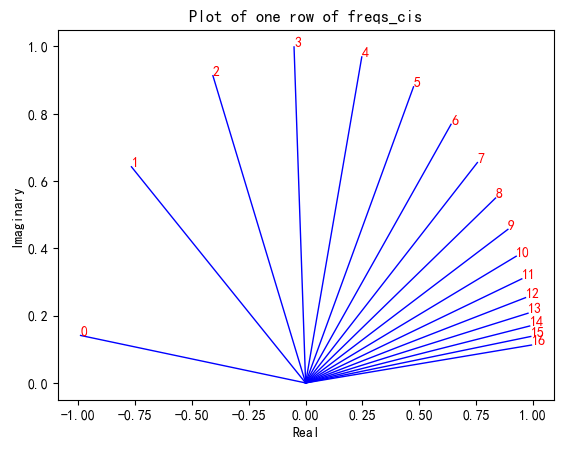

In [817]:
# 查看 freqs_cis 的第三行
value = freqs_cis[3]
plt.figure()
for i, element in enumerate(value[:17]):
    # element.real横坐标值，表示实部, element.imag纵坐标值，表示虚部。。
    plt.plot([0, element.real], [0, element.imag], color='blue', linewidth=1, label=f"Index: {i}")
    plt.annotate(f"{i}", xy=(element.real, element.imag), color='red')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Plot of one row of freqs_cis')
plt.show()

### 现在，每个词元的查询元素都有一个复数（角度变化向量）表示
我们可以将查询（我们拆分为成对的查询）转换为复数，然后根据位置利用点积来旋转 query。

In [818]:
# 将向量转为复数表示
def view_as_complex(real_np):
    shape = real_np.shape
    # 确保最后一个维度是2，表示实部和虚部
    if shape[-1]!=2:
        raise ValueError("Last dimension size must be 2 to represent real and imaginary parts.")
    # 将最后一个维度合并为复数表示
    complex_np =real_np[...,0] + 1j * real_np[..., 1]
    return complex_np

In [819]:
# 转为复数表示
q_per_token_as_complex_numbers = view_as_complex(q_per_token_split_into_pairs)
q_per_token_as_complex_numbers.shape

(17, 64)

In [820]:
q_per_token_as_complex_numbers

array([[-0.0754397 -0.10875705j,  0.27185252-0.21116523j,
         0.2641937 -0.37335274j, ...,  0.19324124-0.17202586j,
         0.1764547 +0.5089048j ,  0.17500934+0.08437597j],
       [ 0.70285165+0.06936354j,  2.0636885 -0.936924j  ,
         1.4372531 -2.0994408j , ...,  0.5442188 -0.12263928j,
         0.55806845+1.078353j  ,  0.6119809 +0.3748193j ],
       [ 0.17687635-0.2447137j ,  0.37319994-0.65336484j,
         0.5938763 -0.873073j  , ..., -0.13144921-0.20891535j,
         0.6322495 +0.63572824j,  0.7268566 +0.99263793j],
       ...,
       [ 0.17687635-0.2447137j ,  0.37319994-0.65336484j,
         0.5938763 -0.873073j  , ..., -0.13144921-0.20891535j,
         0.6322495 +0.63572824j,  0.7268566 +0.99263793j],
       [ 0.7768667 +0.05523063j,  2.1002913 -0.99491274j,
         1.4716086 -2.0712147j , ...,  0.60202795-0.20747076j,
         0.5676714 +1.0456854j ,  0.7605667 +0.5235697j ],
       [ 0.6433331 -0.0409137j ,  1.5277781 -0.95719326j,
         1.1521351 -1.6244192j

In [821]:
# 旋转
q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis
q_per_token_as_complex_numbers_rotated.shape

(17, 64)

### 获得旋转向量后
我们需要将复数转为实数查询

In [822]:
# 将向量转为实数表示
def view_as_real(complex_np):
    # 获取复数张量的形状
    shape = complex_np.shape
    # 创建一个形状为 (...,2) 的新数组，用于存储实部和虚部
    # real_np = np.zeros(shape + (2,), dtype=complex_np.dtype)
    real_np = np.zeros(shape + (2,), dtype=float)
    # 将复数数组的实部和虚部分别存储到新数组的最后一个维度
    real_np[..., 0] = np.real(complex_np)
    real_np[..., 1] = np.imag(complex_np)
    return real_np

In [823]:
# 转为实数表示
q_per_token_split_into_pairs_rotated = view_as_real(q_per_token_as_complex_numbers_rotated)
q_per_token_split_into_pairs_rotated.shape

(17, 64, 2)

In [824]:
q_per_token_split_into_pairs_rotated

array([[[-0.0754397 , -0.10875705],
        [ 0.27185252, -0.21116523],
        [ 0.26419371, -0.37335274],
        ...,
        [ 0.19324124, -0.17202586],
        [ 0.17645469,  0.50890481],
        [ 0.17500934,  0.08437597]],

       [[ 0.32138496,  0.62890655],
        [ 2.09757101,  0.8583896 ],
        [ 2.425405  , -0.76860837],
        ...,
        [ 0.54421923, -0.12263726],
        [ 0.5580652 ,  1.07835473],
        [ 0.61197999,  0.37482081]],

       [[ 0.148911  ,  0.26267004],
        [ 0.63045283,  0.41072258],
        [ 0.9905358 ,  0.3657654 ],
        ...,
        [-0.13144766, -0.20891633],
        [ 0.63224564,  0.63573205],
        [ 0.72685172,  0.9926415 ]],

       ...,

       [[ 0.26660077,  0.14175354],
        [-0.45101566, -0.60228621],
        [-0.4715698 ,  0.94475786],
        ...,
        [-0.13143839, -0.20892216],
        [ 0.63222265,  0.63575492],
        [ 0.72682247,  0.99266292]],

       [[-0.62609203,  0.46322891],
        [ 1.63657491, -1.65

旋转的查询对现在被合并，我们可以获得一个新的查询向量（旋转的查询向量），其形状为 [17x128]，其中 17 是词元(token)数，128 是查询向量的维度。


In [825]:
# 合并为新的查询
q_per_token_rotated = q_per_token_split_into_pairs_rotated.reshape(q_per_token.shape)
q_per_token_rotated.shape

(17, 128)

# 键（与查询几乎相同）
<div>
    <img src="images/keys.png" width="600px"/>
</div>

<br>
&gt; 键生成键向量的维度也是 128 
<br>
&gt; 键的权重数只有查询的 1/4，这是因为键的权重一次性共享在 4 个头上， 以减少所需的计算的次数。
<br>
&gt; 就像查询一样，键也会被旋转以添加位置信息。

In [826]:
# 对键的每个头进行拆分
k_layer0 = tensor_to_numpy(model["layers.0.attention.wk.weight"])
k_layer0 = k_layer0.reshape(n_kv_heads, k_layer0.shape[0] // n_kv_heads, dim)
k_layer0.shape

(8, 128, 4096)

In [827]:
k_layer0_head0 = k_layer0[0]
k_layer0_head0.shape

(128, 4096)

In [828]:
# 与词元嵌入相乘
k_per_token = np.matmul(token_embeddings, k_layer0_head0.T)
k_per_token.shape

(17, 128)

In [829]:
# 转换维度
k_per_token_split_into_pairs = k_per_token.reshape(k_per_token.shape[0], -1, 2)
k_per_token_split_into_pairs.shape

(17, 64, 2)

In [830]:
# 复数表示
k_per_token_as_complex_numbers = view_as_complex(k_per_token_split_into_pairs)
k_per_token_as_complex_numbers.shape

(17, 64)

In [831]:
# 旋转并转为实数表示
k_per_token_split_into_pairs_rotated = view_as_real(k_per_token_as_complex_numbers * freqs_cis)
k_per_token_split_into_pairs_rotated.shape

(17, 64, 2)

In [832]:
# 合并为新的键
k_per_token_rotated = k_per_token_split_into_pairs_rotated.reshape(k_per_token.shape)
k_per_token_rotated.shape

(17, 128)

## 在此阶段，现在每个词元(toekn)都具有旋转后的查询和键。
<div>
    <img src="images/keys0.png" width="600px"/>
</div>
每个查询和键的形状都是 [17x128] 。

## 在下一步中，我们需要将查询和键的矩阵相乘
这样做我们会获得每个词元(toekn)之间相互映射的分数。
<br>
这个分数描述了每个词元(toekn)的查询与每个词元(toekn)的键的相关性。 **这就是自注意力**
<br>
注意力得分矩阵 （qk_per_token） 的形状为 [17x17]，其中 17 是提示词中的词元(token)数
<div>
    <img src="images/qkmatmul.png" width="600px"/>
</div>

In [833]:
qk_per_token = np.matmul(q_per_token_rotated, k_per_token_rotated.T)/(head_dim)**0.5
qk_per_token.shape

(17, 17)

# 现在，我们需要屏蔽查询(Q)、键(K)的分数
在 llama3 的训练过程中，未来的词元(toekn)的 QK 分数是被屏蔽的。
<br>
这是因为在训练过程中，我们只学习使用过去的词元(toekn)来预测词元(toekn)。
<br>
因此，在推理过程中，我们将未来词元(toekn)设置为零。
<div>
    <img src="images/mask.png" width="600px"/>
</div>

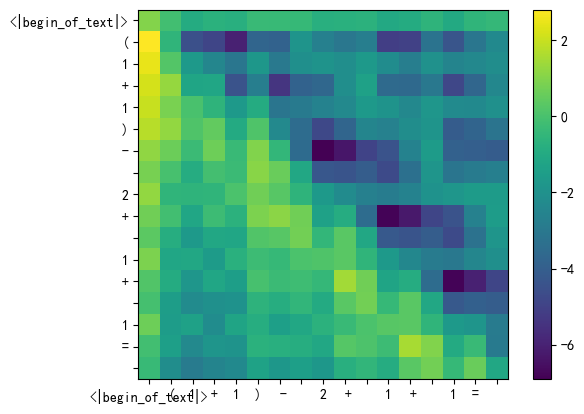

In [834]:
def display_qk_heatmap(qk_per_token):
    _, ax = plt.subplots()
    im = ax.imshow(qk_per_token, cmap='viridis')
    ax.set_xticks(range(len(prompt_split_as_tokens)))
    ax.set_yticks(range(len(prompt_split_as_tokens)))
    ax.set_xticklabels(prompt_split_as_tokens)
    ax.set_yticklabels(prompt_split_as_tokens)
    ax.figure.colorbar(im, ax=ax)
    
display_qk_heatmap(qk_per_token)

In [835]:
# 构建掩码矩阵
mask = np.full((len(tokens), len(tokens)), float("-inf"))
mask = np.triu(mask, k=1)
print(mask.shape)
print(mask)

(17, 17)
[[  0. -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf]
 [  0.   0. -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf]
 [  0.   0.   0. -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf]
 [  0.   0.   0.   0. -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf]
 [  0.   0.   0.   0.   0. -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf]
 [  0.   0.   0.   0.   0.   0. -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf]
 [  0.   0.   0.   0.   0.   0.   0. -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf]
 [  0.   0.   0.   0.   0.   0.   0.   0. -inf -inf -inf -inf -inf -inf
  -inf -inf -inf]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. -inf -inf -inf -inf -inf
  -inf -inf -inf]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. -inf -inf -inf -inf
  -inf -inf -inf]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. -inf -inf -inf
  -inf -inf -inf]
 

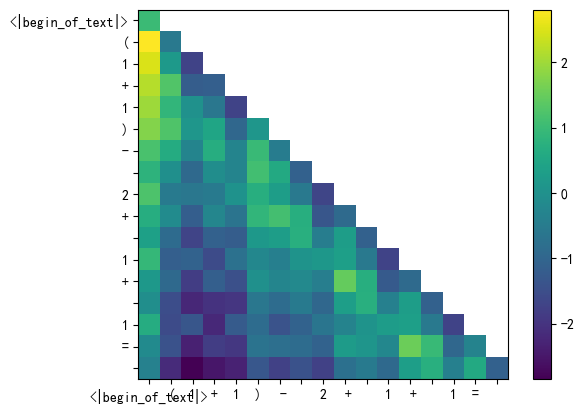

In [836]:
# 对矩阵进行掩码操作
qk_per_token_after_masking = qk_per_token + mask
display_qk_heatmap(qk_per_token_after_masking)

<div>
    <img src="images/softmax.png" width="600px"/><br>
    <img src="images/softmax-formula.png" width="600px"/>
</div>

In [837]:
# 定义softmax函数
def softmax(X, axis=0):
    exp_x = np.exp(X - np.max(X, axis=axis, keepdims=True))
    return exp_x/exp_x.sum(axis=axis, keepdims=True)

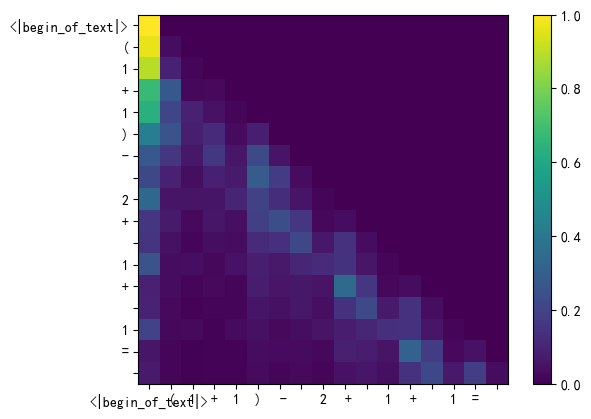

In [838]:
# 对每一行进行softmax操作
qk_per_token_after_masking_after_softmax = softmax(qk_per_token_after_masking, axis=1)
display_qk_heatmap(qk_per_token_after_masking_after_softmax)

## 值

<div>
    <img src="images/value.png" width="600px"/>
</div>
these scores (0-1) are used to determine how much of value matrix is used per token<br>
这些分数(0-1) 用于确定每个词元(token)的值矩阵的使用情况
<br>
&gt; 就像键一样，值权重也是一次共享在 4 个注意头（以减少计算量），
<br>
&gt; 因此，下面的值权重矩阵的形状为 [8x128x4096]


In [839]:
# 对每个注意力头的值进行拆分
v_layer0 = tensor_to_numpy(model["layers.0.attention.wv.weight"])
v_layer0 = v_layer0.reshape(n_kv_heads, v_layer0.shape[0] // n_kv_heads, dim)
v_layer0.shape

(8, 128, 4096)

第一层第一个头的值权重矩阵如下

In [840]:
v_layer0_head0 = v_layer0[0]
v_layer0_head0.shape

(128, 4096)

## 值向量
<div>
    <img src="images/v0.png" width="600px"/>
</div>
现在，我们使用值 weghts 来获取每个词元(token)的注意值，其大小为 [17x128]，其中 17 是提示词中的词元(token)数，128 是每个词元(token)的值向量维度。

In [841]:
# 值与词元相乘
v_per_token = np.matmul(token_embeddings, v_layer0_head0.T)
v_per_token.shape

(17, 128)

## 注意力(Attention)
<div>
    <img src="images/attention.png" width="600px"/>
</div>
与每个词元(token)的值相乘后的最终的注意力向量的形状为 [17*128]

In [842]:
qkv_attention = np.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
qkv_attention.shape

(17, 128)

# 多头注意力(multi head attention)
<div>
    <img src="images/heads.png" width="600px"/>
</div>
WE NOW HAVE THE ATTENTION VALUE OF THE FIRST LAYER AND FIRST HEAD<br>
我们现在有第一层和第一层的第一个头的注意力值
<br>
现在我将实现一个循环，针对第一层中的每个头执行与上面单元格完全相同的数学运算。

In [843]:
qkv_attention_store = []
# 循环第一层中的所有注意力头
for head in range(n_heads):
    # 获得第一层的每个head的Q、K、V的权重
    q_layer0_head = q_layer0[head]
    k_layer0_head = k_layer0[head//4] # key weights are shared across 4 heads
    v_layer0_head = v_layer0[head//4] # value weights are shared across 4 heads
    # 获得第一层的每个head的Q、K、V的权重与embeddings相乘
    q_per_token = np.matmul(token_embeddings, q_layer0_head.T)
    k_per_token = np.matmul(token_embeddings, k_layer0_head.T)
    v_per_token = np.matmul(token_embeddings, v_layer0_head.T)
    # 对Q进行旋转
    q_per_token_split_into_pairs = q_per_token.reshape(q_per_token.shape[0], -1, 2)
    q_per_token_as_complex_numbers = view_as_complex(q_per_token_split_into_pairs)
    q_per_token_split_into_pairs_rotated = view_as_real(q_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    q_per_token_rotated = q_per_token_split_into_pairs_rotated.reshape(q_per_token.shape)
    # 对K进行旋转
    k_per_token_split_into_pairs = k_per_token.reshape(k_per_token.shape[0], -1, 2)
    k_per_token_as_complex_numbers = view_as_complex(k_per_token_split_into_pairs)
    k_per_token_split_into_pairs_rotated = view_as_real(k_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    k_per_token_rotated = k_per_token_split_into_pairs_rotated.reshape(k_per_token.shape)
    # 旋转后的Q、K相乘，获得自注意力得分
    qk_per_token = np.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
    # 掩码操作
    mask = np.full((len(tokens), len(tokens)), float("-inf"))
    mask = np.triu(mask, k=1)
    qk_per_token_after_masking = qk_per_token + mask
    qk_per_token_after_masking_after_softmax = softmax(qk_per_token_after_masking, axis=1)
    # 与V相乘获得每个token的注意力
    qkv_attention = np.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention = np.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention_store.append(qkv_attention)

len(qkv_attention_store)

32

In [844]:
qkv_attention_store

[array([[ 0.01537907,  0.00080452,  0.03338384, ..., -0.02471023,
         -0.00279481,  0.06470558],
        [ 0.01566281,  0.00130613,  0.03183354, ..., -0.02448549,
         -0.00238193,  0.06548499],
        [ 0.01575462,  0.00196168,  0.028726  , ..., -0.02385549,
         -0.00079202,  0.06397362],
        ...,
        [ 0.00499266, -0.00482836,  0.00902216, ..., -0.01028487,
          0.01158501, -0.0058325 ],
        [ 0.00656133, -0.00119386, -0.00061078, ..., -0.00651523,
          0.00469018,  0.02277954],
        [ 0.01113592,  0.01190765,  0.00177246, ..., -0.00987829,
          0.01444967,  0.01980855]]),
 array([[ 0.01537907,  0.00080452,  0.03338384, ..., -0.02471023,
         -0.00279481,  0.06470558],
        [ 0.01640844,  0.00262431,  0.02775948, ..., -0.02389488,
         -0.0012969 ,  0.0675332 ],
        [ 0.02281697,  0.01457924, -0.01056085, ..., -0.01811198,
          0.00987564,  0.08290022],
        ...,
        [ 0.00404296, -0.00739575, -0.00897595, ..., -

<div>
    <img src="images/stacked.png" width="600px"/>
</div>
我们现在有一个第一层上所有(32个)头的qkv_attention矩阵，接下来将所有注意力得分合并到一个大小为 [17x4096]
的大矩阵中。


In [845]:
# 合并所有的注意力得分到一个大矩阵中
stacked_qkv_attention = np.concatenate(qkv_attention_store, axis=-1)
stacked_qkv_attention.shape

(17, 4096)

# 权重矩阵（马上到最后了！）
<div>
    <img src="images/weightmatrix.png" width="600px"/>
</div>
one of the last things to do for a layer 0 attention is, is to multiply the weight matrix of the <br>
对于第 0 层的注意力要做的最后一件事是去乘输出的权重矩阵

In [846]:
w_layer0 = tensor_to_numpy(model["layers.0.attention.wo.weight"])
w_layer0.shape

(4096, 4096)

### 这是一个简单的线性层，所以我们只是进行矩阵乘法

In [847]:
embedding_delta = np.matmul(stacked_qkv_attention, w_layer0.T)
embedding_delta.shape

(17, 4096)

<div>
    <img src="images/afterattention.png" width="600px"/>
</div>
现在，我们获得了经过了注意的嵌入值，应该将它加到词元(token)嵌入(embeddings)中

In [848]:
embedding_after_edit = token_embeddings_unnormalized + embedding_delta
embedding_after_edit.shape

(17, 4096)

## 我们对嵌入增量(embedding delta)先进行归一化，然后运行前馈神经网络
<div>
    <img src="images/norm_after.png" width="600px"/>
</div>

In [849]:
# 归一化 
embedding_after_edit_normalized = rms_norm(embedding_after_edit, tensor_to_numpy(model["layers.0.ffn_norm.weight"]))
embedding_after_edit_normalized.shape

(17, 4096)

## 加载 **前馈网络(Feed Forward  Network,FFN)** 权重并实现前馈网络
<div>
    <img src="images/swiglu.png" width="600px"/><br>
    <img src="images/Swish.png" width="600px"/><br>
    <img src="images/SwiGLU1.png" width="600px"/>
</div>
in llama3, they used a SwiGLU feedforward network, this network architecture is really good at adding non linearity when needed by the model.<br>
在 llama3 中，它们使用了 SwiGLU 前馈网络，这种网络架构非常擅长在模型需要时添加非线性。
<br>
如今，在 LLMS 中使用这种前馈网络架构非常标准。

In [850]:
# 使用Numpy实现的silu函数（即Swish激活函数）
def silu(x):
    # 计算 sigmod(x)
    sigmod_x = 1 / (1 + np.exp(-x))
    # 计算 SiLU(x) = x* sigmoid(x)
    return x * sigmod_x
# silu(np.matmul(embedding_after_edit_normalized, w1.T))

In [851]:
print(
    tensor_to_numpy(model["layers.0.feed_forward.w1.weight"]).shape,
    tensor_to_numpy(model["layers.0.feed_forward.w2.weight"]).shape,
    tensor_to_numpy(model["layers.0.feed_forward.w3.weight"]).shape
)

(14336, 4096) (4096, 14336) (14336, 4096)


In [852]:
w1 = tensor_to_numpy(model["layers.0.feed_forward.w1.weight"])
w2 = tensor_to_numpy(model["layers.0.feed_forward.w2.weight"])
w3 = tensor_to_numpy(model["layers.0.feed_forward.w3.weight"])
# SwiGLU 激活
output_after_feedforward = np.matmul(silu(np.matmul(embedding_after_edit_normalized, w1.T)) * np.matmul(embedding_after_edit_normalized, w3.T), w2.T)
output_after_feedforward.shape

(17, 4096)

# 在第一层之后，我们终于为每个词元(TOKEN)提供了新的编辑嵌入(EDITED EMBEDDINGS)
在我们完成之前，还有 31 个层（循环）
<br>
you can imagine this edited embedding as having information about all queries asked on the first layer<br>
您可以将这种编辑后的嵌入想象为包含有关第一层上请求的所有查询的信息。
<br>
now each layer will encode more and more complex queries on the quesions asked, until we have an embedding that knows everything about the next token that we need.<br>
现在每一层都将对所提出的问题进行越来越复杂的查询编码，直到我们有一个嵌入，它知道我们需要的下一个词元(token)的所有信息。

In [853]:
layer_0_embedding = embedding_after_edit+output_after_feedforward
layer_0_embedding.shape

(17, 4096)

# 对每层进行循环(快结束了)
<div>
    <img src="images/god.png" width="600px"/>
</div>
针对每一层，将我们之前所做的操作进行循环，一次性完成。
<br>


In [854]:
# 存储嵌入
final_embedding = token_embeddings_unnormalized
# 对每层进行循环
for layer in range(n_layers):
    # 存储Q、K、V注意力得分
    qkv_attention_store = []
    # 获取每层的Q、K、V、O权重信息
    layer_embedding_norm = rms_norm(final_embedding, tensor_to_numpy(model[f"layers.{layer}.attention_norm.weight"]))
    q_layer = tensor_to_numpy(model[f"layers.{layer}.attention.wq.weight"])
    q_layer = q_layer.reshape(n_heads, q_layer.shape[0] // n_heads, dim)
    k_layer = tensor_to_numpy(model[f"layers.{layer}.attention.wk.weight"])
    k_layer = k_layer.reshape(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)
    v_layer = tensor_to_numpy(model[f"layers.{layer}.attention.wv.weight"])
    v_layer = v_layer.reshape(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)
    w_layer = tensor_to_numpy(model[f"layers.{layer}.attention.wo.weight"])
    # 遍历所有注意力头
    for head in range(n_heads):
        # 获得第一层的每个head的Q、K、V的权重
        q_layer_head = q_layer[head]
        k_layer_head = k_layer[head//4]
        v_layer_head = v_layer[head//4]
        # 获得第一层的每个head的权重与embedings相乘
        q_per_token = np.matmul(layer_embedding_norm, q_layer_head.T)
        k_per_token = np.matmul(layer_embedding_norm, k_layer_head.T)
        v_per_token = np.matmul(layer_embedding_norm, v_layer_head.T)
        # 对Q、K进行旋转
        q_per_token_split_into_pairs = q_per_token.reshape(q_per_token.shape[0], -1, 2)
        q_per_token_as_complex_numbers = view_as_complex(q_per_token_split_into_pairs)
        q_per_token_split_into_pairs_rotated = view_as_real(q_per_token_as_complex_numbers * freqs_cis)
        q_per_token_rotated = q_per_token_split_into_pairs_rotated.reshape(q_per_token.shape)
        k_per_token_split_into_pairs = k_per_token.reshape(k_per_token.shape[0], -1, 2)
        k_per_token_as_complex_numbers = view_as_complex(k_per_token_split_into_pairs)
        k_per_token_split_into_pairs_rotated = view_as_real(k_per_token_as_complex_numbers * freqs_cis)
        k_per_token_rotated = k_per_token_split_into_pairs_rotated.reshape(k_per_token.shape)
        # 旋转后的Q、K相乘，获得自注意力得分
        qk_per_token = np.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
        mask = np.full((len(token_embeddings_unnormalized), len(token_embeddings_unnormalized)), float("-inf"))
        # 掩码操作
        mask = np.triu(mask, k=1)
        qk_per_token_after_masking = qk_per_token + mask
        qk_per_token_after_masking_after_softmax = softmax(qk_per_token_after_masking, axis=1)
        qkv_attention = np.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
        # 与V相乘获得每个token的注意力得分
        qkv_attention_store.append(qkv_attention)
    # 合并，获得多头注意力得分
    stacked_qkv_attention = np.concatenate(qkv_attention_store, axis=-1)
    # w_layer = tensor_to_numpy(model[f"layers.{layer}.attention.wo.weight"])
    embedding_delta = np.matmul(stacked_qkv_attention, w_layer.T)
    embedding_after_edit = final_embedding + embedding_delta
    # 归一化
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, tensor_to_numpy(model[f"layers.{layer}.ffn_norm.weight"]))
    # SwiGLU 激活
    w1 = tensor_to_numpy(model[f"layers.{layer}.feed_forward.w1.weight"])
    w2 = tensor_to_numpy(model[f"layers.{layer}.feed_forward.w2.weight"])
    w3 = tensor_to_numpy(model[f"layers.{layer}.feed_forward.w3.weight"])
    output_after_feedforward = np.matmul(silu(np.matmul(embedding_after_edit_normalized, w1.T)) * np.matmul(embedding_after_edit_normalized, w3.T), w2.T)
    # 相加获得最终的embedding
    final_embedding = embedding_after_edit+output_after_feedforward

# 我们现在有了最终的嵌入，这是模型可以对下一个词元(token)做出的最佳猜测
嵌入的形状与常规词元(token)嵌入 [17x4096] 相同，其中 17 是词元(token)数，4096 是嵌入维度
<div>
    <img src="images/last_norm.png" width="600px"/>
</div>

In [855]:
# 归一化
final_embedding = rms_norm(final_embedding, tensor_to_numpy(model["norm.weight"]))
final_embedding.shape

(17, 4096)

# 最后，让我们解码嵌入到词元(token)值中
<div>
    <img src="images/finallayer.png" width="600px"/>
</div>
我们将使用输出解码器将最终嵌入转换为一个词元(token)

In [856]:
tensor_to_numpy(model["output.weight"]).shape

(128256, 4096)

# 我们使用最后一个词元(token)的嵌入来预测下一个值

在理想的情况下，我们期望得到的值是，42 <br>
note：42 是"the answer to the ultimate question of life, the universe, and everything is "的答案，根据《银河系漫游指南》一书得出的，大多数 MORDERN LLM 在这里会回答 42，来验证我们的整个代码！

In [857]:
# 最终的线性层相乘
logits = np.matmul(final_embedding[-1], tensor_to_numpy(model["output.weight"]).T)
logits.shape

(128256,)

### 模型预测下一个token为 2983 ，这是 42 的编码吗？

In [858]:
next_token = np.argmax(logits, axis=-1)
next_token

17

# 解码
<div>
    <img src="images/42.png" width="600px"/>
</div>

In [859]:
tokenizer.decode([next_token.item()])

'2'